## Here we will doing the same classification task of seperating higgs boson from zz background with the xgboost package. 

The first steps are exactly the same as of the keras example.

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import uproot3


In [4]:
signal = uproot3.open("Higgs_signal.root")["Events"]

In [5]:
signal.keys()

[b'Muon_pt_1',
 b'Muon_pt_2',
 b'Electron_pt_1',
 b'Electron_pt_2',
 b'dPhim1e1',
 b'dPhim1e2',
 b'dPhim2e1',
 b'dPhim2e2',
 b'Electron_eta_1',
 b'Electron_eta_2',
 b'Muon_eta_1',
 b'Muon_eta_2',
 b'dPhim1m2',
 b'dPhie1e2']

In [6]:
df_signal = signal.pandas.df(["Muon_*","Elec*","dPhi*"])

In [7]:
background = uproot3.open("Higgs_background.root")["Events"]

In [8]:
df_background = background.pandas.df(["Mu*","Ele*","dPhi*"])

In [9]:
df_background.describe()

,Muon_pt_1,Muon_pt_2,Muon_eta_1,Muon_eta_2,Electron_pt_1,Electron_pt_2,Electron_eta_1,Electron_eta_2,dPhim1e1,dPhim1e2,dPhim2e1,dPhim2e2,dPhim1m2,dPhie1e2
count,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000,131384.000000
mean,28.916653,28.885139,-0.042383,0.038036,31.968166,32.504166,-0.003966,0.004052,-0.167671,-0.138970,0.098707,0.127410,-0.266382,0.028703
std,29.118668,64.374405,1.391685,1.048500,26.931080,28.713284,1.124343,1.333354,2.654039,2.655514,2.617703,2.625995,2.548379,2.715871
min,3.000166,3.000157,-5.696682,-4.053686,5.000047,5.000191,-2.676136,-2.654118,-6.260075,-6.277071,-6.261344,-6.261574,-6.277163,-6.262017
25%,9.061773,7.824332,-1.294580,-0.699660,13.454914,12.663032,-0.821138,-1.072187,-2.412053,-2.396323,-2.036037,-2.049057,-2.377479,-2.546266
50%,20.908807,19.833357,-0.073071,0.044886,26.475896,26.501304,-0.000442,0.002865,-0.158305,-0.128462,0.076944,0.103246,-0.288105,0.034173
75%,39.534593,39.247039,1.236784,0.777958,41.454762,42.257981,0.813468,1.086277,2.000439,2.071269,2.280156,2.363670,1.581809,2.605508
max,1897.867920,16244.873047,2.510320,5.592937,598.043518,677.865173,2.664995,2.669436,6.268476,6.246774,6.275122,6.254691,6.257235,6.264532


In [10]:
df_signal=df_signal.assign(y=1)
df_background =df_background.assign(y=0)

In [11]:
df_list = [df_signal,df_background]

In [12]:
df = pd.concat(df_list)

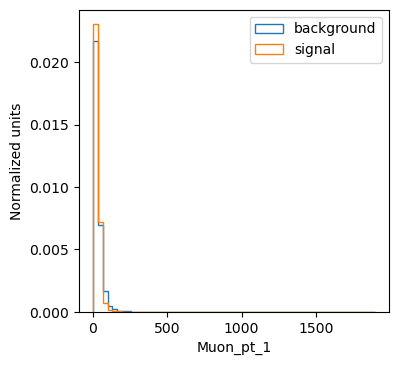

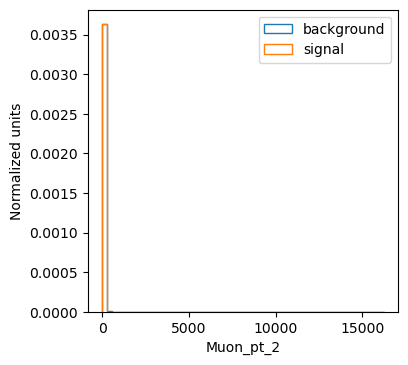

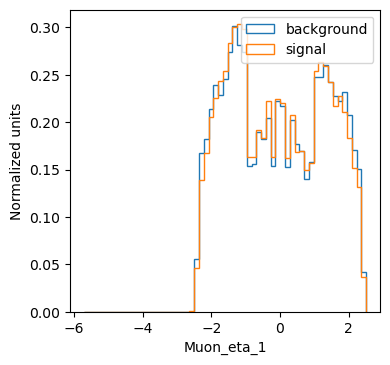

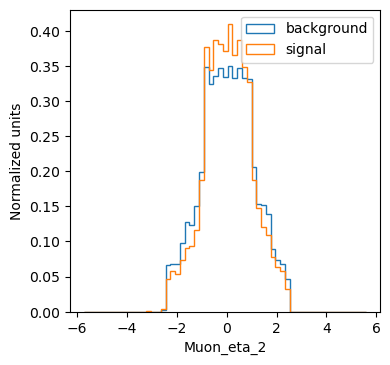

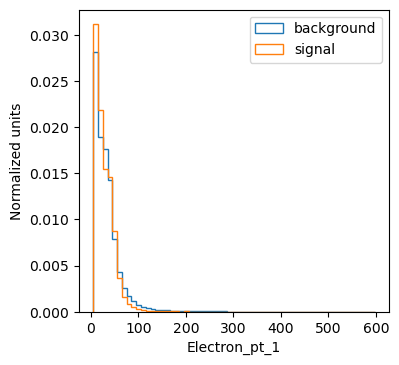

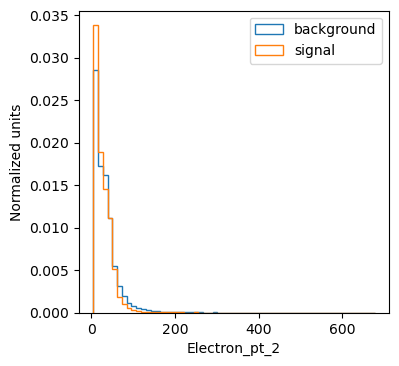

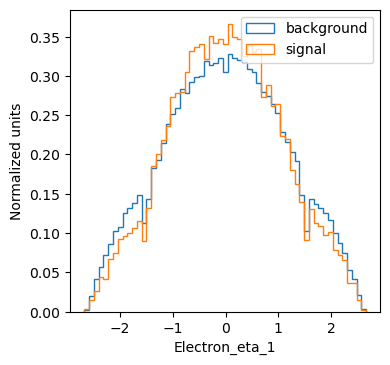

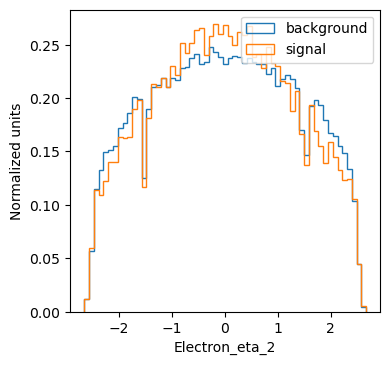

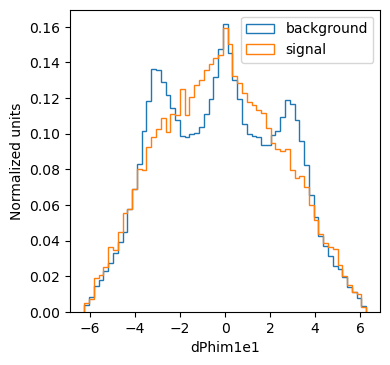

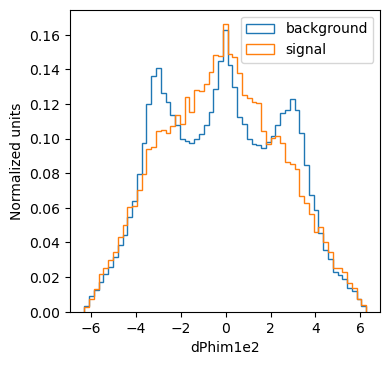

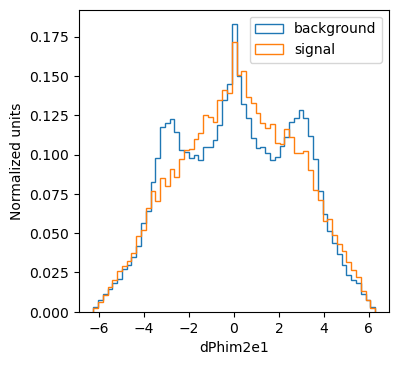

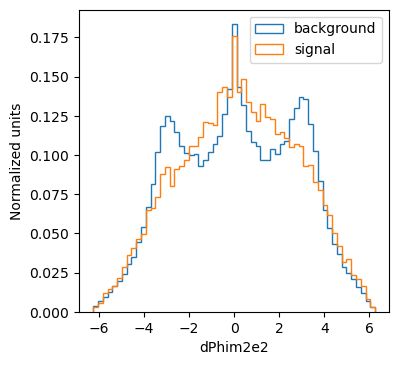

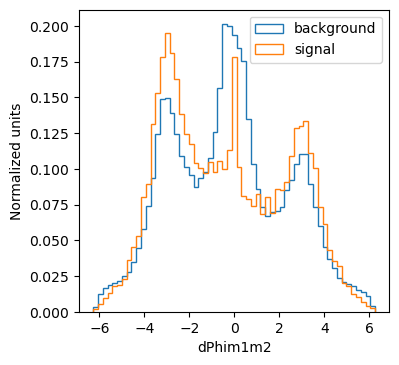

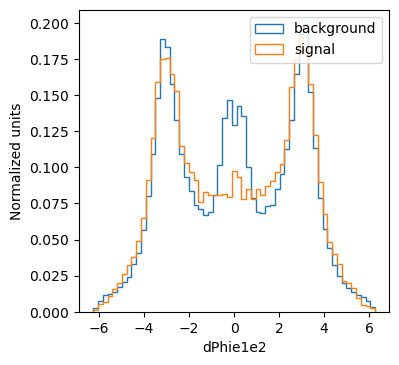

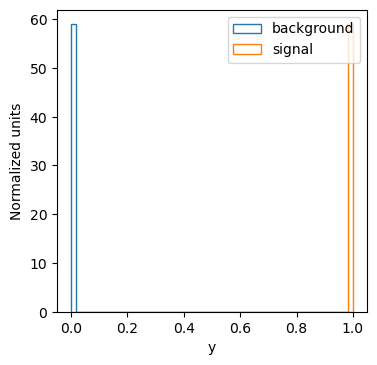

In [13]:
# iterate through the columns
for key in df.keys():
    # plotting settings
    #matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(4, 4), dpi=100)
    bins = np.linspace(min(df[key]), max(df[key]), 60)
    # plot!
    plt.hist(df[df.y<0.5][key], bins=bins, histtype='step',label='background',density=1)
    plt.hist(df[df.y>=0.5][key], bins=bins, histtype='step',label='signal',density=1)
    
    # decorate
    plt.xlabel(key)
    plt.ylabel('Normalized units')
    plt.legend()
    plt.plot()
    #plt.savefig("{}.png".format(key), bbox_inches="tight")

In [14]:
dataset = df.values

In [15]:
X = dataset[:,0:14] # since we have 14 variables in this example
y = dataset[:,14]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test, y_train,y_test = train_test_split(X, y,
                                                  test_size=0.20, random_state=42)

## Now we come to the training part

In [18]:
import xgboost as xgb

### Now let us construct our xgboost model. The hyperparameters that you should mention are the number of trees(n_estmators), max depth( ie the maximum allowed depth that a  tree can have),the learning rate or the shrinkage

In [19]:
cls=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=100, missing=None, n_estimators=600, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.8, scale_pos_weight=6, seed=None,
              silent=None, subsample=0.5, verbosity=1)

see https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn for the complete description of these parameters

Here scale_pos_weight is similar to the class weightage that we game before.Since our background events are about 6 times the signal events, we give it as 6.Subsample ratio of the training instances.Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

In [20]:
cls.fit(X_train, y_train) #training

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=100, missing=None, monotone_constraints='()',
              n_estimators=600, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1.8, scale_pos_weight=6,
              seed=0, silent=None, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [23]:
print ('from train sample')
train_scores = cls.predict_proba(X_train)

from train sample


In [24]:
test_scores = cls.predict_proba(X_test)

In [25]:
print(test_scores)

[[0.49336785 0.50663215]
 [0.09954435 0.90045565]
 [0.89929646 0.10070353]
 ...
 [0.8068578  0.19314218]
 [0.9402432  0.05975682]
 [0.45765626 0.54234374]]


the first column predicts the probablity of an event being background and the second column predicts the probability that the event is signal.Let us take the second column ie the signal column to get our bdt output

In [29]:
from sklearn.metrics import roc_curve,auc

In [30]:
fpr_tr, tpr_tr, tresholds_tr = roc_curve(y_train, train_scores[:,1],pos_label=None, sample_weight=None)

In [31]:
fpr_te, tpr_te, tresholds_te = roc_curve(y_test, test_scores[:,1], pos_label=None, sample_weight=None)

In [32]:
train_auc = auc(fpr_tr, tpr_tr)

In [33]:
print("BDT train set auc - {}".format(train_auc))
print ('from train sample')

BDT train set auc - 0.9054386952296769
from train sample


In [35]:
test_auc = auc(fpr_te, tpr_te)
print("BDT test set auc - {}".format(test_auc))

BDT test set auc - 0.8799038202611037


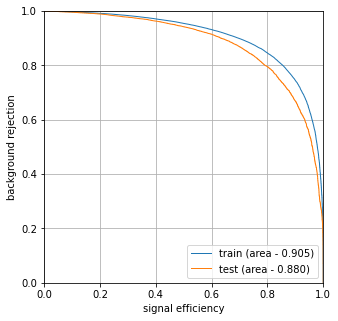

In [36]:
#ROC curve
fig, ax = plt.subplots(figsize=(5,5))
#ax.plot(tpr_tr, tpr_tr, lw=1, label='train (area - %0.3f)'%(train_auc))
ax.plot(tpr_tr, 1-fpr_tr, lw=1, label='train (area - %0.3f)'%(train_auc))
ax.plot(tpr_te, 1-fpr_te, lw=1, label='test (area - %0.3f)'%(test_auc))
ax.grid()
ax.legend(loc="lower right")
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
fig.savefig("roc_xgb.png")

In [39]:
bkg_score = cls.predict_proba(X_test[y_test<0.5])[:,1] #bdt output for background test events

In [41]:
sig_score = cls.predict_proba(X_test[y_test>0.5])[:,1]  #bdt output for signal test events

In [37]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=20):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
         d1 = clf.predict_proba(X[y>0.5])[:, 1].ravel()
         d2 = clf.predict_proba(X[y<0.5])[:, 1].ravel()
         decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    plt.subplots(figsize=(6,6))
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=(0,1), bins=bins,
             histtype='step', density=1,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=(0,1), bins=bins,
             histtype='step', density=1,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=(0,1), density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='none', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=(0,1), density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='none', c='b', label='B (test)')
    
    plt.xlabel("XGB output")
    plt.ylabel("Normalized units")
    plt.legend(loc='best')
    plt.savefig("Xgboutput.png", bbox_inches="tight")

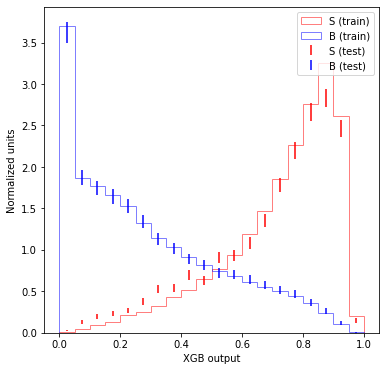

In [38]:
compare_train_test(cls,X_train,y_train,X_test,y_test)